In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from frvrs_utils import FRVRSUtilities
from notebook_utils import NotebookUtilities
import humanize
import matplotlib.pyplot as plt
import os
import os.path as osp
import re

nu = NotebookUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)
fu = FRVRSUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)
PNG_PATH = '../saves/png'
os.makedirs(name=PNG_PATH, exist_ok=True)


# Visualize DM/Patient Interactions

In [3]:

# Attempt to load the logs data frame
frvrs_logs_df = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df')['frvrs_logs_df']
print(frvrs_logs_df.shape)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
(829116, 114)



## Visualize the Order of Responder Negotiations on one scene's timeline

In [4]:

import pandas as pd

# Create a boolean mask to filter action types
start_stop_list = ['SESSION_END', 'SESSION_START']
patient_mask_series = frvrs_logs_df.action_type.isin(fu.responder_negotiations_list + start_stop_list)

# Include VOICE_COMMAND actions with specific messages in the mask
patient_mask_series |= ((frvrs_logs_df.action_type == 'VOICE_COMMAND') & (frvrs_logs_df.voice_command_message.isin(fu.command_messages_list)))

# Group each patient, run, and session with non-null patient IDs
scene_gb = frvrs_logs_df[patient_mask_series].sort_values(['action_tick']).groupby(fu.scene_groupby_columns)

# Loop through each unique file/scene/patient combination
time_groups_dict = {}
consecutive_time_groups_dict = {}
for (session_uuid, scene_id), scene_df in scene_gb:
    key = (session_uuid, scene_id)
    actions_list = []
    action_types_set = set()
    for row_index, row_series in scene_df.iterrows():
        action_type = row_series.voice_command_message
        if pd.notnull(action_type):
            actions_list.append(action_type)
            action_types_set.add(action_type)
        action_type = row_series.action_type
        if pd.notnull(action_type) and (action_type != 'VOICE_COMMAND'):
            actions_list.append(action_type)
            action_types_set.add(action_type)
    time_groups_dict[key] = actions_list
    for action_type in action_types_set: actions_list = fu.replace_consecutive_elements(actions_list, element=action_type)
    consecutive_time_groups_dict[key] = actions_list

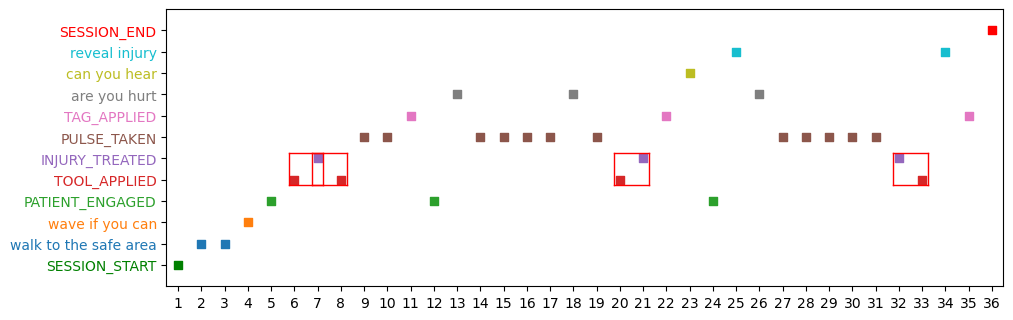

In [5]:

# Plot the action type sequence with a specific number of negotiations
scene_tuple, sequence = [(k, v) for k, v in time_groups_dict.items() if len(v) == 36][0]

# Build a list of the first of each action type
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1]) & patient_mask_series
scene_df = frvrs_logs_df[mask_series].sort_values('action_tick').set_index('action_tick')
actions_list = []
for action_tick, row_series in scene_df.iterrows():
    action_type = row_series.voice_command_message
    if pd.notnull(action_type) and (action_type not in actions_list): actions_list.append(action_type)
    action_type = row_series.action_type
    if pd.notnull(action_type) and (action_type != 'VOICE_COMMAND') and (action_type not in actions_list): actions_list.append(action_type)

color_dict = {'SESSION_START': 'green', 'SESSION_END': 'red'}
# print(sequence)
highlighted_ngrams = [['TOOL_APPLIED', 'INJURY_TREATED'], ['INJURY_TREATED', 'TOOL_APPLIED']]
if(sequence): ax = nu.plot_sequence(sequence, highlighted_ngrams=highlighted_ngrams, color_dict=color_dict, alphabet_list=actions_list, verbose=False);

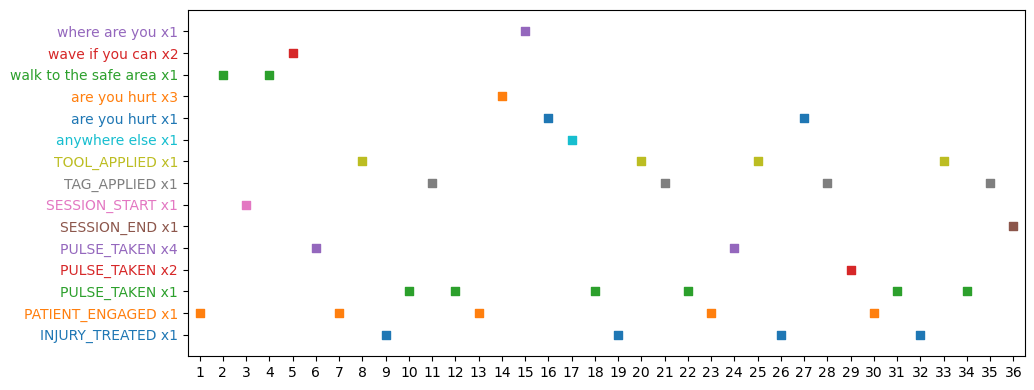

In [6]:

# Plot the consecutive time groups sequence with the fewest number of groupings
scene_tuple, sequence = [(k, v) for k, v in consecutive_time_groups_dict.items() if len(v) == 36][0]
color_dict = {'SESSION_START': 'green', 'SESSION_END': 'red'}
# print(nu.get_alphabet(sequence))
if(sequence): ax = nu.plot_sequence(sequence, color_dict=color_dict, verbose=False);

In [7]:

# from pysan import get_ndistinct_subsequences

def get_ndistinct_subsequences(sequence, verbose=False):
    
    # This implementation works on strings, so parse non-strings to strings
    if (type(sequence) is not str) or (not all([(len(str(e)) == 1) for e in sequence])):
        new_sequence, string_to_integer_map = nu.convert_strings_to_integers(sequence, alphabet_list=None)
        sequence = []
        for e in new_sequence: sequence.append(e)
    if verbose: print('sequence', sequence)

    # Create an array to store index of last
    last = [-1 for i in range(256 + 1)] # hard-coded value needs explaining -ojs

    # Length of input string
    sequence_length = len(sequence)

    # dp[i] is going to store count of discount subsequence of length of i
    dp = [-2 for i in range(sequence_length + 1)]

    # Empty substring has only one subseqence
    dp[0] = 1

    # Traverse through all lengths from 1 to n 
    for i in range(1, sequence_length + 1):

        # Number of subseqence with substring str[0...i-1]
        dp[i] = 2 * dp[i - 1]

        # If current character has appeared before, then remove all subseqences ending with previous occurrence
        if last[sequence[i - 1]] != -1: dp[i] = dp[i] - dp[last[sequence[i - 1]]]

        last[sequence[i - 1]] = i - 1

    return dp[sequence_length]

In [8]:

# from pysan import get_turbulence
import statistics

def get_turbulence(sequence, verbose=False):
    '''
    Computes turbulence for a given sequence, based on
    [Elzinga & Liefbroer's 2007 definition](https://www.researchgate.net/publication/225402919_De-standardization_of_Family-Life_Trajectories_of_Young_Adults_A_Cross-National_Comparison_Using_Sequence_Analysis)
    which is also implemented in the [TraMineR](http://traminer.unige.ch/doc/seqST.html) sequence analysis library.
    '''
    phi = get_ndistinct_subsequences(sequence, verbose=verbose)
    if verbose: print('phi', phi)
    
    state_durations = [value for key, value in get_spells(sequence)]
    if verbose: print('durations', state_durations)
    if verbose: print('mean duration', statistics.mean(state_durations))
    
    try: variance_of_state_durations = statistics.variance(state_durations)
    except: variance_of_state_durations = 0.0
    if verbose: print('variance', variance_of_state_durations)
    
    tbar = statistics.mean(state_durations)
    
    maximum_state_duration_variance = (len(sequence) - 1) * (1 - tbar) ** 2
    if verbose: print('smax', maximum_state_duration_variance)
    
    top_right = maximum_state_duration_variance + 1
    bot_right = variance_of_state_durations + 1

    import math
    turbulence = math.log2(phi * (top_right / bot_right))
    if verbose: print('turbulence', turbulence)
    
    return turbulence

In [9]:

from pysan import get_entropy
from pysan import get_complexity
from pysan.statistics import get_spells

rows_list = []
for scene_tuple, sequence in time_groups_dict.items():
    row_dict = {}
    row_dict['session_uuid'] = scene_tuple[0]
    row_dict['scene_id'] = scene_tuple[1]
    row_dict['entropy'] = get_entropy(sequence)
    row_dict['turbulence'] = get_turbulence(sequence, verbose=False)
    row_dict['complexity'] = get_complexity(sequence)
    rows_list.append(row_dict)
summary_statistics_df = pd.DataFrame(rows_list)

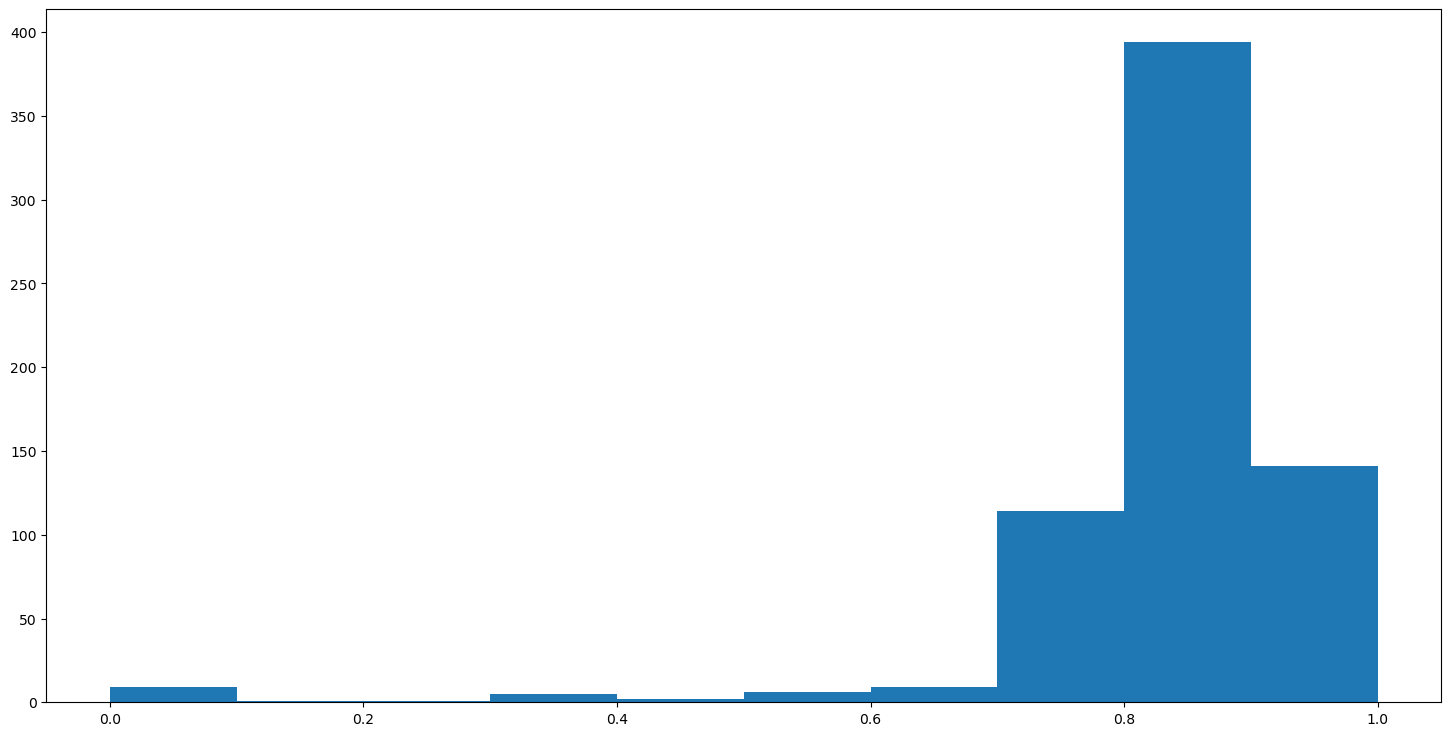

In [10]:

# get_xtick_text = lambda text_obj: text_obj.get_position()[0]
# AxesSubplot_obj = nu.plot_histogram(summary_statistics_df, 'entropy', 'Entropy', get_xtick_text, 'Entropy')
fig, ax = plt.subplots(figsize=(18, 9))
summary_statistics_df.entropy.hist(ax=ax)
plt.grid(False);

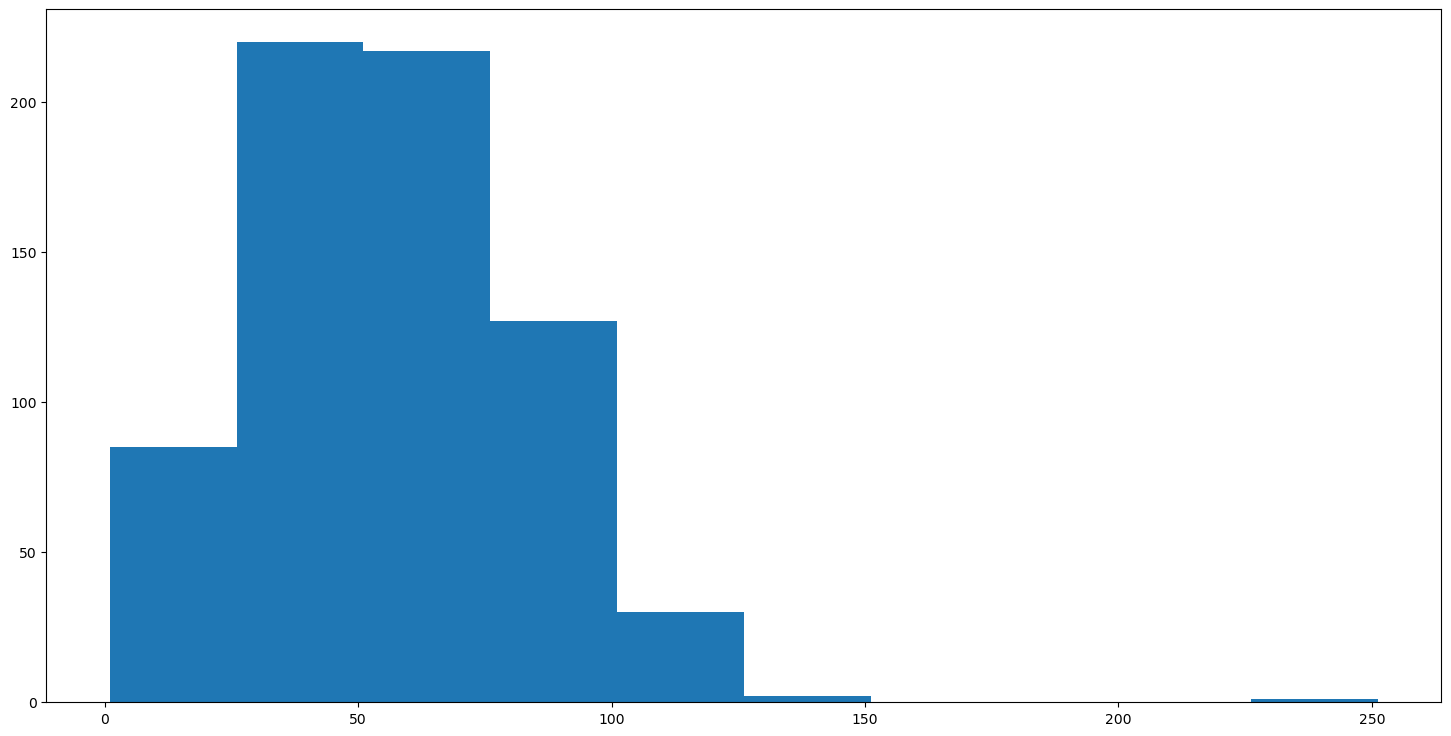

In [11]:

# AxesSubplot_obj = nu.plot_histogram(summary_statistics_df, 'turbulence', 'Turbulence', get_xtick_text, 'Turbulence')
fig, ax = plt.subplots(figsize=(18, 9))
summary_statistics_df.turbulence.hist(ax=ax)
plt.grid(False);

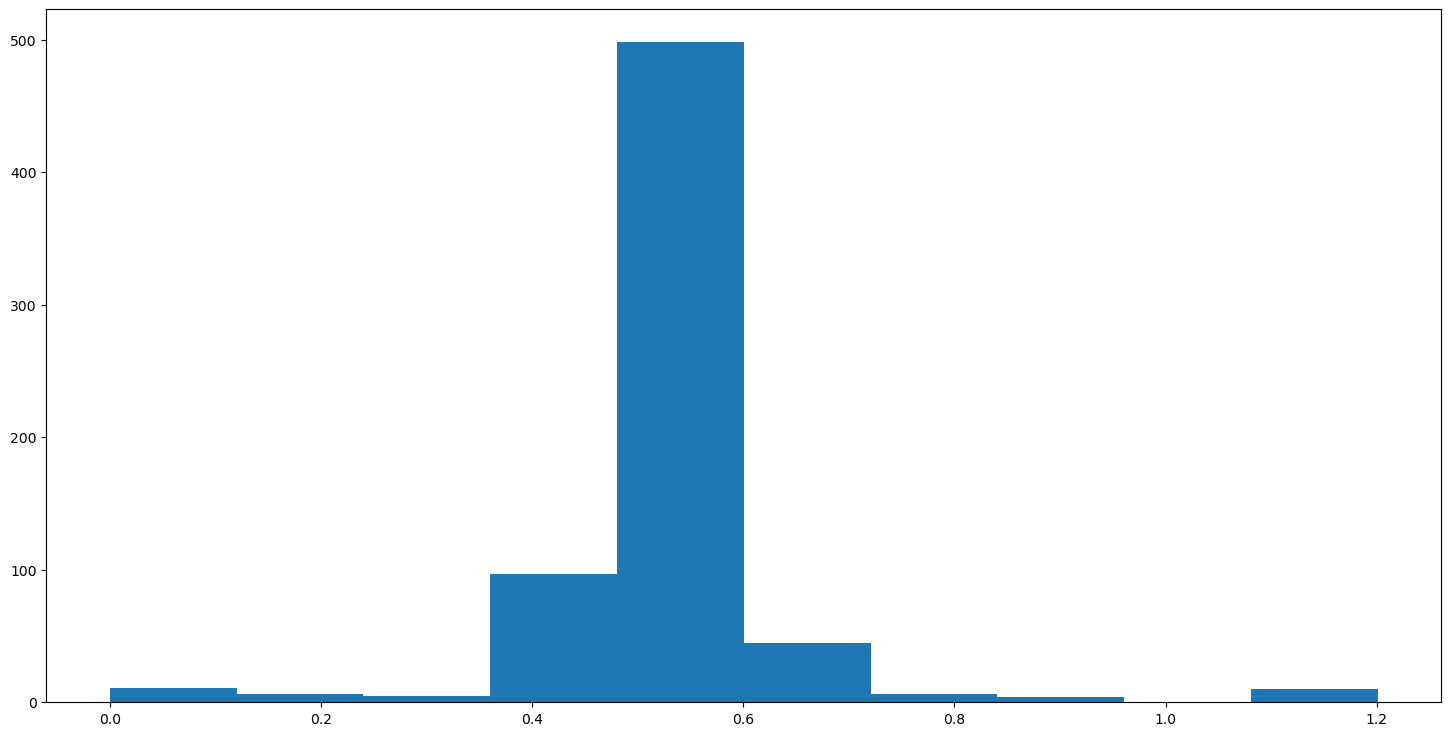

In [12]:

# AxesSubplot_obj = nu.plot_histogram(summary_statistics_df, 'complexity', 'Complexity', get_xtick_text, 'Complexity')
fig, ax = plt.subplots(figsize=(18, 9))
# display(fu.get_statistics(summary_statistics_df, ['complexity']))
# display(summary_statistics_df.complexity.mode())
summary_statistics_df.complexity.hist(ax=ax)
plt.grid(False);

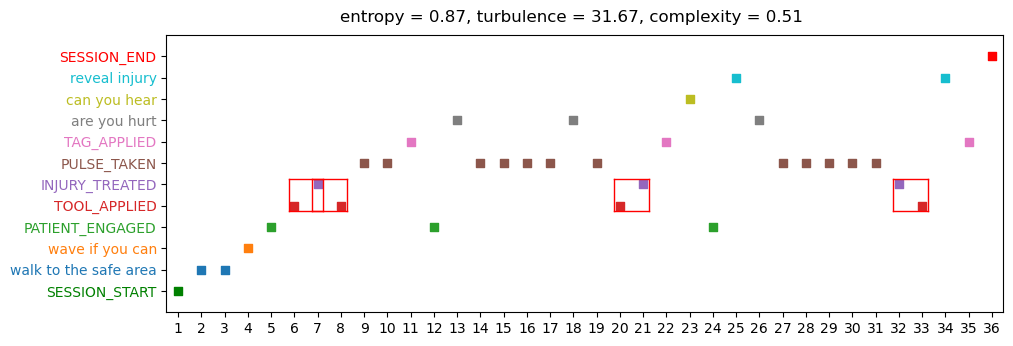

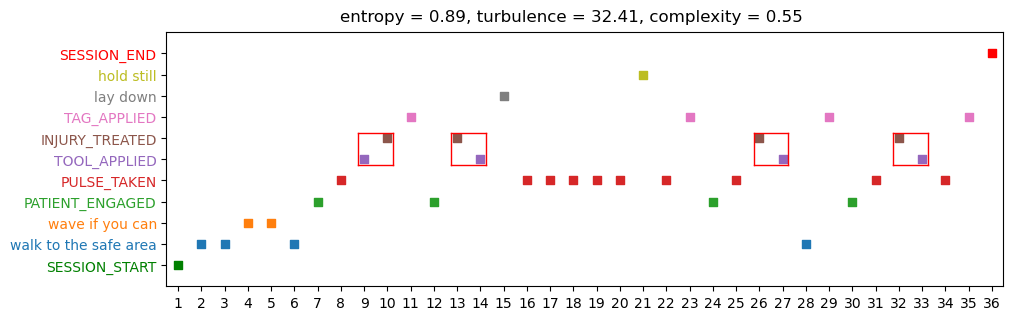

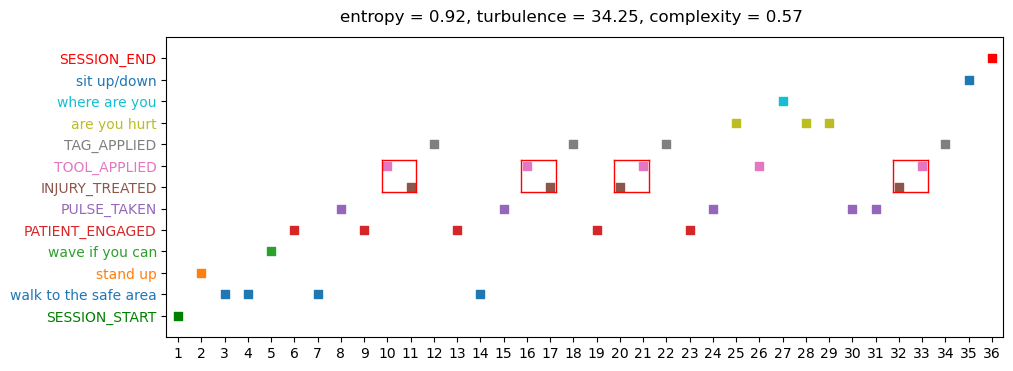

In [13]:

# Plot all the action type sequences with 36 negotiations
highlighted_ngrams = [['TOOL_APPLIED', 'INJURY_TREATED'], ['INJURY_TREATED', 'TOOL_APPLIED']]
color_dict = {'SESSION_START': 'green', 'SESSION_END': 'red'}
for scene_tuple, sequence in [(k, v) for k, v in time_groups_dict.items() if len(v) == 36][:3]:
    
    # Create a plot title with summary statistics
    mask_series = (summary_statistics_df.session_uuid == scene_tuple[0]) & (summary_statistics_df.scene_id == scene_tuple[1])
    df = summary_statistics_df[mask_series]
    entropy = df.entropy.squeeze()
    turbulence = df.turbulence.squeeze()
    complexity = df.complexity.squeeze()
    suptitle = f'entropy = {entropy:0.2f}, turbulence = {turbulence:0.2f}, complexity = {complexity:0.2f}'
    
    # Build a list of the first of each action type
    mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1]) & patient_mask_series
    scene_df = frvrs_logs_df[mask_series].sort_values('action_tick').set_index('action_tick')
    actions_list = []
    for action_tick, row_series in scene_df.iterrows():
        action_type = row_series.voice_command_message
        if pd.notnull(action_type) and (action_type not in actions_list): actions_list.append(action_type)
        action_type = row_series.action_type
        if pd.notnull(action_type) and (action_type != 'VOICE_COMMAND') and (action_type not in actions_list): actions_list.append(action_type)
    
    # print(sequence)
    if(sequence): fig = nu.plot_sequence(
        sequence, highlighted_ngrams=highlighted_ngrams, color_dict=color_dict, suptitle=suptitle, alphabet_list=actions_list, verbose=False
    );

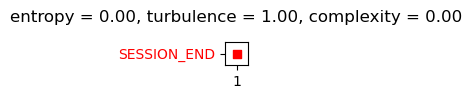

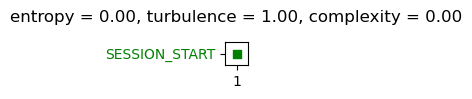

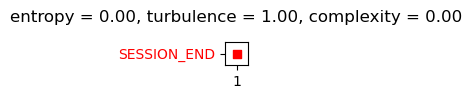

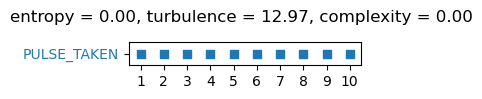

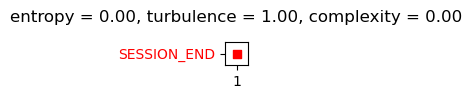

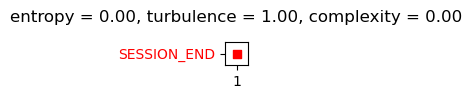

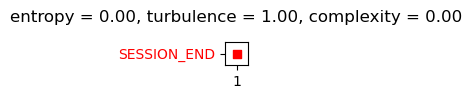

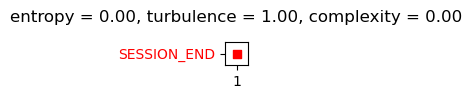

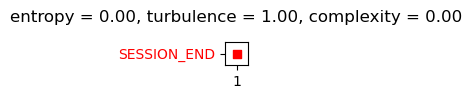

In [16]:

# Plot what minimum entropy looks like
min_entropy = summary_statistics_df.entropy.min()
mask_series = (summary_statistics_df.entropy == min_entropy)
verbose = True
for row_index, row_series in summary_statistics_df[mask_series].iterrows():
    session_uuid = row_series.session_uuid
    scene_id = row_series.scene_id
    scene_tuple = (session_uuid, scene_id) # ('c6a48228-d864-4b20-93dd-8ad0d78d59c0', 0)
    if scene_tuple in time_groups_dict:
        sequence = time_groups_dict[scene_tuple]
        # if len(sequence) > 1: print(scene_tuple)
        
        # Create a plot title with summary statistics
        mask_series = (summary_statistics_df.session_uuid == session_uuid) & (summary_statistics_df.scene_id == scene_id)
        df = summary_statistics_df[mask_series]
        turbulence = df.turbulence.squeeze()
        complexity = df.complexity.squeeze()
        suptitle = f'entropy = {min_entropy:0.2f}, turbulence = {turbulence:0.2f}, complexity = {complexity:0.2f}'
        
        # Build a list of the first of each action type
        mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == scene_id) & patient_mask_series
        scene_df = frvrs_logs_df[mask_series].sort_values('action_tick').set_index('action_tick')
        actions_list = []
        for action_tick, row_series in scene_df.iterrows():
            action_type = row_series.voice_command_message
            if pd.notnull(action_type) and (action_type not in actions_list): actions_list.append(action_type)
            action_type = row_series.action_type
            if pd.notnull(action_type) and (action_type != 'VOICE_COMMAND') and (action_type not in actions_list): actions_list.append(action_type)
        
        # print(sequence)
        if(sequence): fig = nu.plot_sequence(
            sequence, highlighted_ngrams=highlighted_ngrams, color_dict=color_dict, suptitle=suptitle, alphabet_list=actions_list, verbose=False
        )
        verbose = False

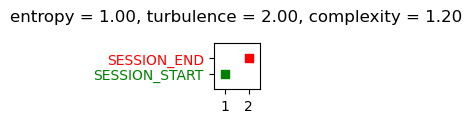

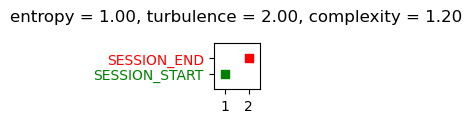

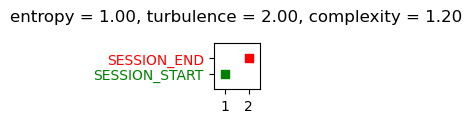

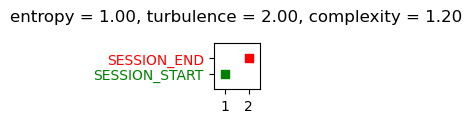

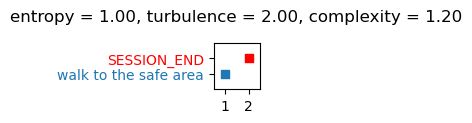

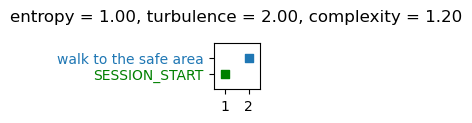

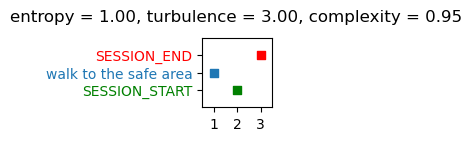

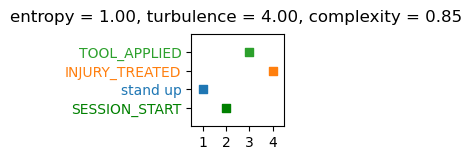

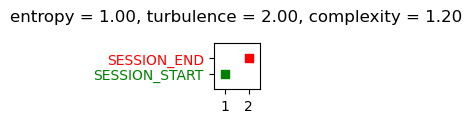

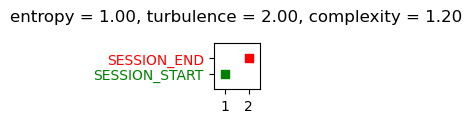

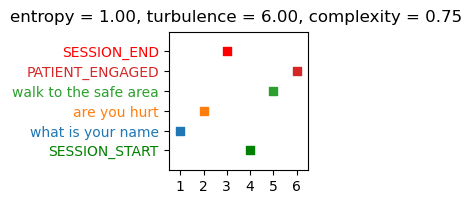

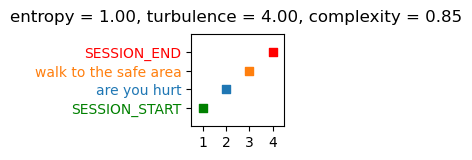

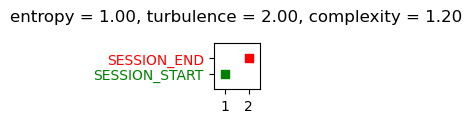

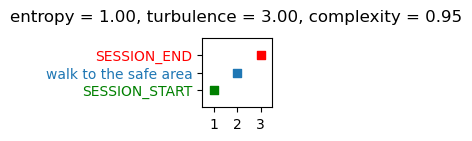

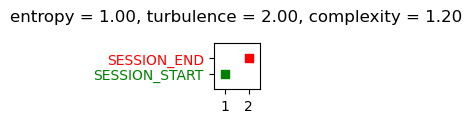

In [17]:

# Plot what maximum entropy looks like
max_entropy = summary_statistics_df.entropy.max()
mask_series = (summary_statistics_df.entropy == max_entropy)
verbose = True
for row_index, row_series in summary_statistics_df[mask_series].iterrows():
    session_uuid = row_series.session_uuid
    scene_id = row_series.scene_id
    scene_tuple = (session_uuid, scene_id) # ('8ec8afba-8533-4915-898f-5769c1258c61', 0)
    if scene_tuple in time_groups_dict:
        sequence = time_groups_dict[scene_tuple]
        # if len(sequence) > 5: print(scene_tuple)
        
        # Create a plot title with summary statistics
        mask_series = (summary_statistics_df.session_uuid == session_uuid) & (summary_statistics_df.scene_id == scene_id)
        df = summary_statistics_df[mask_series]
        turbulence = df.turbulence.squeeze()
        complexity = df.complexity.squeeze()
        suptitle = f'entropy = {max_entropy:0.2f}, turbulence = {turbulence:0.2f}, complexity = {complexity:0.2f}'
        
        # Build a list of the first of each action type
        mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == scene_id) & patient_mask_series
        scene_df = frvrs_logs_df[mask_series].sort_values('action_tick').set_index('action_tick')
        actions_list = []
        for action_tick, row_series in scene_df.iterrows():
            action_type = row_series.voice_command_message
            if pd.notnull(action_type) and (action_type not in actions_list): actions_list.append(action_type)
            action_type = row_series.action_type
            if pd.notnull(action_type) and (action_type != 'VOICE_COMMAND') and (action_type not in actions_list): actions_list.append(action_type)
        
        # print(sequence)
        if(sequence): fig = nu.plot_sequence(
            sequence, highlighted_ngrams=highlighted_ngrams, color_dict=color_dict, suptitle=suptitle, alphabet_list=actions_list, verbose=False
        )
        verbose = False

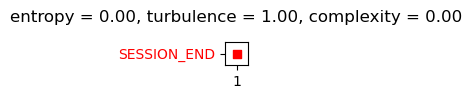

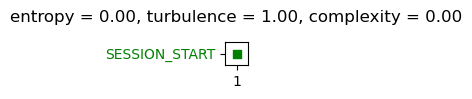

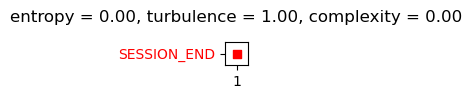

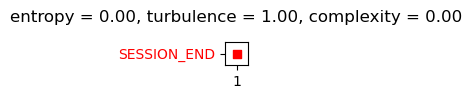

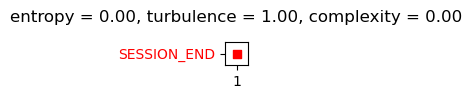

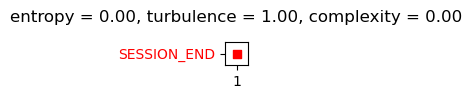

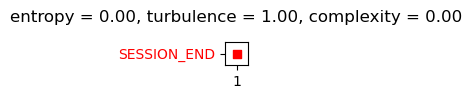

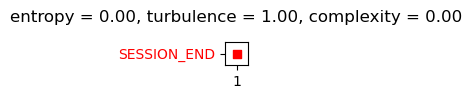

In [18]:

# Plot what minimum turbulence looks like
min_turbulence = summary_statistics_df.turbulence.min()
mask_series = (summary_statistics_df.turbulence == min_turbulence)
verbose = True
for row_index, row_series in summary_statistics_df[mask_series].iterrows():
    session_uuid = row_series.session_uuid
    scene_id = row_series.scene_id
    scene_tuple = (session_uuid, scene_id) # ('c6a48228-d864-4b20-93dd-8ad0d78d59c0', 0)
    if scene_tuple in time_groups_dict:
        sequence = time_groups_dict[scene_tuple]
        # if len(sequence) > 1: print(scene_tuple)
        
        # Create a plot title with summary statistics
        mask_series = (summary_statistics_df.session_uuid == session_uuid) & (summary_statistics_df.scene_id == scene_id)
        df = summary_statistics_df[mask_series]
        entropy = df.entropy.squeeze()
        complexity = df.complexity.squeeze()
        suptitle = f'entropy = {entropy:0.2f}, turbulence = {min_turbulence:0.2f}, complexity = {complexity:0.2f}'
        
        # Build a list of the first of each action type
        mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == scene_id) & patient_mask_series
        scene_df = frvrs_logs_df[mask_series].sort_values('action_tick').set_index('action_tick')
        actions_list = []
        for action_tick, row_series in scene_df.iterrows():
            action_type = row_series.voice_command_message
            if pd.notnull(action_type) and (action_type not in actions_list): actions_list.append(action_type)
            action_type = row_series.action_type
            if pd.notnull(action_type) and (action_type != 'VOICE_COMMAND') and (action_type not in actions_list): actions_list.append(action_type)
        
        # print(sequence)
        if(sequence): fig = nu.plot_sequence(
            sequence, highlighted_ngrams=highlighted_ngrams, color_dict=color_dict, suptitle=suptitle, alphabet_list=actions_list, verbose=False
        )
        verbose = False

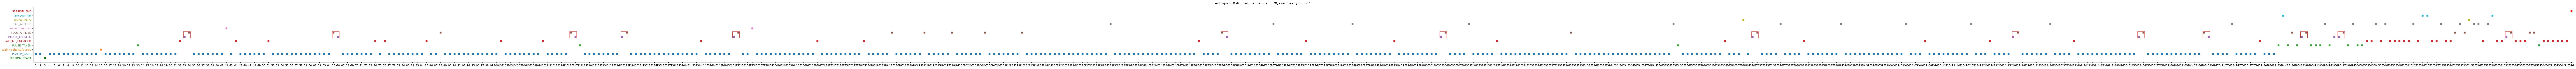

In [19]:

# Plot what maximum turbulence looks like
max_turbulence = summary_statistics_df.turbulence.max()
mask_series = (summary_statistics_df.turbulence == max_turbulence)
verbose = True
for row_index, row_series in summary_statistics_df[mask_series].iterrows():
    session_uuid = row_series.session_uuid
    scene_id = row_series.scene_id
    scene_tuple = (session_uuid, scene_id) # ('c6a48228-d864-4b20-93dd-8ad0d78d59c0', 0)
    if scene_tuple in time_groups_dict:
        sequence = time_groups_dict[scene_tuple]
        # if len(sequence) > 1: print(scene_tuple)
        
        # Create a plot title with summary statistics
        mask_series = (summary_statistics_df.session_uuid == session_uuid) & (summary_statistics_df.scene_id == scene_id)
        df = summary_statistics_df[mask_series]
        entropy = df.entropy.squeeze()
        complexity = df.complexity.squeeze()
        suptitle = f'entropy = {entropy:0.2f}, turbulence = {max_turbulence:0.2f}, complexity = {complexity:0.2f}'
        
        # Build a list of the first of each action type
        mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == scene_id) & patient_mask_series
        scene_df = frvrs_logs_df[mask_series].sort_values('action_tick').set_index('action_tick')
        actions_list = []
        for action_tick, row_series in scene_df.iterrows():
            action_type = row_series.voice_command_message
            if pd.notnull(action_type) and (action_type not in actions_list): actions_list.append(action_type)
            action_type = row_series.action_type
            if pd.notnull(action_type) and (action_type != 'VOICE_COMMAND') and (action_type not in actions_list): actions_list.append(action_type)
        
        # print(sequence)
        if(sequence): fig = nu.plot_sequence(
            sequence, highlighted_ngrams=highlighted_ngrams, color_dict=color_dict, suptitle=suptitle, alphabet_list=actions_list, verbose=False
        )
        verbose = False